In [1]:
import openmc
import matplotlib.pyplot as plt
import numpy as np
import tokamak_radiation_environment as tre

In [16]:
# read weight windows
iter_settings = openmc.Settings.from_xml("../reactors/iter_class/model.xml")
arc_settings = openmc.Settings.from_xml("../reactors/arc_class/model.xml")

In [2]:
iter_sp = openmc.StatePoint("../reactors/iter_class/statepoint.010.h5")
arc_sp = openmc.StatePoint("../reactors/arc_class/statepoint.005.h5")

In [3]:
iter_tfcoil_spectrum = iter_sp.get_tally(id=4)
arc_tfcoil_spectrum = arc_sp.get_tally(id=4)

iter_spectrum_mean = iter_tfcoil_spectrum.mean[:,0,0]
arc_spectrum_mean = arc_tfcoil_spectrum.mean[:,0,0]

iter_spectrum_stddev = iter_tfcoil_spectrum.std_dev[:,0,0]
arc_spectrum_stddev = arc_tfcoil_spectrum.std_dev[:,0,0]

ebins = iter_tfcoil_spectrum.filters[2].bins[:,0]

In [15]:
iter_gas_production = iter_sp.get_tally(id=3).get_pandas_dataframe()
arc_gas_production = arc_sp.get_tally(id=3).get_pandas_dataframe()

print(iter_gas_production)
print(arc_gas_production)

        mesh 2          nuclide     score     mean std. dev.
             x   y    z                                     
0            1   1    1   total    (n,Xp) 0.00e+00  0.00e+00
1            1   1    1   total    (n,Xd) 0.00e+00  0.00e+00
2            1   1    1   total    (n,Xt) 0.00e+00  0.00e+00
3            1   1    1   total  (n,X3He) 0.00e+00  0.00e+00
4            1   1    1   total    (n,Xa) 0.00e+00  0.00e+00
...        ...  ..  ...     ...       ...      ...       ...
8084995    175  66  140   total    (n,Xp) 0.00e+00  0.00e+00
8084996    175  66  140   total    (n,Xd) 0.00e+00  0.00e+00
8084997    175  66  140   total    (n,Xt) 0.00e+00  0.00e+00
8084998    175  66  140   total  (n,X3He) 0.00e+00  0.00e+00
8084999    175  66  140   total    (n,Xa) 0.00e+00  0.00e+00

[8085000 rows x 7 columns]
        mesh 2          nuclide     score     mean std. dev.
             x   y    z                                     
0            1   1    1   total    (n,Xp) 0.00e+00  0.00e

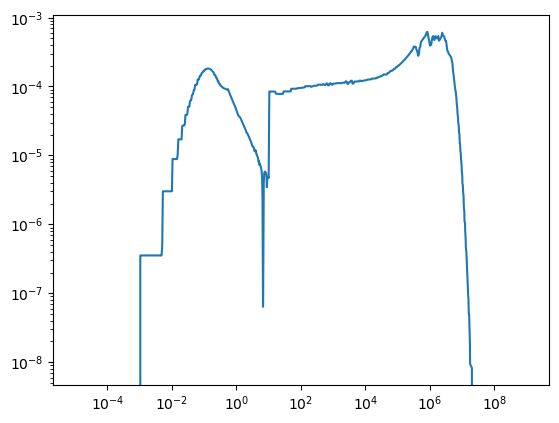

In [4]:
hfir = np.loadtxt('../reactors/ornl_hfir/spectrum.txt')
hfir_ebins = np.flipud(hfir[:1102])
hfir_spectrum = np.flipud(hfir[1103:])
plt.loglog(hfir_ebins, hfir_spectrum)

0.0005830012367008631 0.0020672658749067464


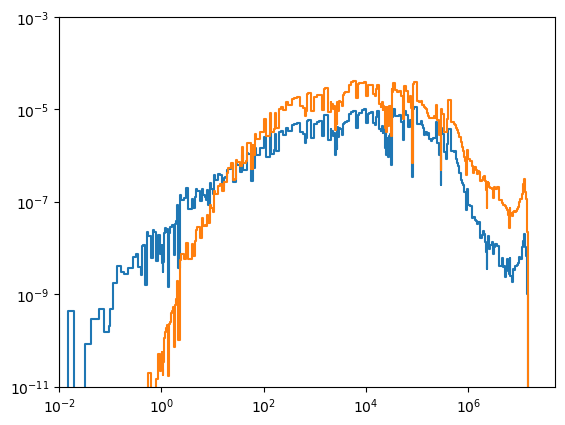

In [14]:
fig, ax = plt.subplots()
ax.plot(ebins, iter_spectrum_mean, drawstyle='steps-pre')
ax.plot(ebins, arc_spectrum_mean, drawstyle='steps-pre')
# ax.plot(hfir_ebins, hfir_spectrum/sum(hfir_spectrum), drawstyle='steps-pre')
ax.set_xlim(1e-2, 5e7)
ax.set_ylim(1e-11, 1e-3)
# ax.set_xlim(1e6, 2e7)
# ax.set_ylim(1e-5, 1e-3)
ax.set_xscale('log')
ax.set_yscale('log')
print(sum(iter_spectrum_mean), sum(arc_spectrum_mean))

/tmp/ipykernel_27535/4124602391.py:1: RuntimeWarning: invalid value encountered in divide
  plt.loglog(iter_tfcoil_spectrum.std_dev[:,0,0] / iter_tfcoil_spectrum.mean[:,0,0])
/tmp/ipykernel_27535/4124602391.py:2: RuntimeWarning: invalid value encountered in divide
  plt.loglog(arc_tfcoil_spectrum.std_dev[:,0,0] / arc_tfcoil_spectrum.mean[:,0,0])


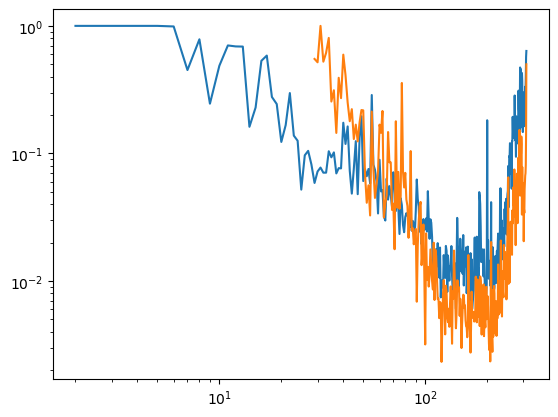

In [6]:
plt.loglog(iter_tfcoil_spectrum.std_dev[:,0,0] / iter_tfcoil_spectrum.mean[:,0,0])
plt.loglog(arc_tfcoil_spectrum.std_dev[:,0,0] / arc_tfcoil_spectrum.mean[:,0,0])

Text(0, 0.5, '')

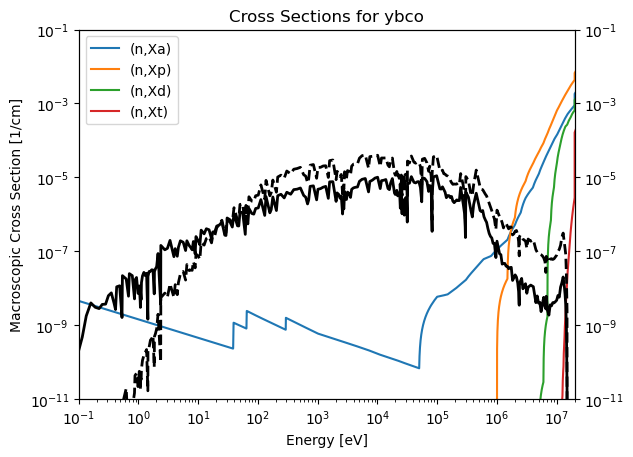

In [11]:
# Specify the materials you want to plot cross sections for
ybco = tre.materials.ybco
nb3sn = tre.materials.nb3sn

# Use openmc.plot_xs to create the cross section plots
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
openmc.plot_xs(nb3sn, ['(n,Xa)', '(n,Xp)', '(n,Xd)', '(n,Xt)'], axis=ax1, c=['k', 'k','k','k'])
# openmc.plot_xs(ybco, ['(n,Xa)'], axis=ax1, c='k')
ax2.plot(ebins, iter_tfcoil_spectrum.mean[:,0,0], lw=2, ls='-', c='k')
ax2.plot(ebins, arc_tfcoil_spectrum.mean[:,0,0], lw=2, ls='--', c='k')
# ax2.plot(hfir_ebins, hfir_spectrum/sum(hfir_spectrum), lw=2, ls=':', c='k')
ax1.set_xlim(1e-1, 2e7), ax2.set_xlim(1e-1, 2e7)
ax1.set_ylim(1e-11, 1e-1), ax2.set_ylim(1e-11, 1e-1)
ax1.set_xscale('log'), ax2.set_xscale('log')
ax1.set_yscale('log'), ax2.set_yscale('log')
ax2.set_ylabel('')